In [1]:
import sys
sys.path.append('..')
from src.Adaline import Adaline
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Descrição do problema

Um sistema de gerenciamento automático de controle de duas válvulas, situado a 500 metros de um processo industrial, envia um sinal codificado constituído de quatro grandezas {x1, x2, x3 e x4} que são necessárias para o ajuste de cada uma das válvulas. Conforme mostra a figura abaixo, a mesma via de comunicação é utilizada para acionamento de ambas as válvulas, sendo que o comutador localizado próximo das válvulas deve decidir se o sinal é para a válvula A ou B.

<img src='../figs/fig1.png'>

Entretanto, durante a transmissão, os sinais sofrem interferências que alteram o conteúdo das informações transmitidas. Para resolver este problema, a equipe de engenheiros e cientistas pretende treinar uma rede ADALINE para classificar os sinais ruidosos, confirmando ao sistema comutador se os dados devem ser encaminhados para o comando de ajuste da válvula A ou B.  
Assim, baseado nas medições dos sinais já com ruídos, formou-se o conjunto de treinamento em anexo, tomando por convenção o valor –1 para os sinais que devem ser encaminhados para o ajuste da válvula A e o valor +1 se os mesmos devem ser enviados para a válvula B. Assim, a estrutura do ADALINE é mostrada na figura seguinte.

<img src='../figs/fig2.png' width='30%'>


## Carregamento dos dados

In [2]:
# Carrega os dados em um pandas DataFrame
df = pd.read_csv('../data/valvulas.csv', header=None)

# Visualiza as 5 primeiras linhas do dataset
df.head()

,0,1,2,3,4
0,0.4329,-1.3719,0.7022,-0.8535,1.0
1,0.3024,0.2286,0.8630,2.7909,-1.0
2,0.1349,-0.6445,1.0530,0.5687,-1.0
3,0.3374,-1.7163,0.3670,-0.6283,-1.0
4,1.1434,-0.0485,0.6637,1.2606,1.0


In [3]:
# Verifica os dtypes do dataset
df.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
dtype: object

## Pré-processamento

In [4]:
# Separa o dataset entre os sinais de entrada (X) e saída (y)
X = df.loc[:, [0, 1, 2, 3]].values
y = df.loc[:, 4].values

# Faz o escalonamento dos sinais de entrada
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Separa o dataset em treino e teste, considerando 70% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.7)

## Treinamento da rede

Primeiramente, treinaremos uma rede ADALINE com inicializando o vetor de pesos em cada treinamento com valores aleatórios entre zero e um. Utilize taxa de aprendizado $\eta$ = 0.001, épocas = 5000 e precisão $\epsilon$ = 0.000001.

In [5]:
# Define a rede ADALINE
rede = Adaline(eta=.001, epoch=5_000, goal=.000_001)
rede.fit(X_train, y_train)

In [6]:
# Verificação dos pesos sinápticos e limiar de ativação
print(f'Pesos sinápticos: {rede.weight_[1:]}')
print(f'Limiar de ativação: {rede.weight_[0]}')
print(f'Número de épocas: {rede.epochs}')

Pesos sinápticos: [ 1.74004777  0.35386176 -0.67810587 -2.57401517]
Limiar de ativação: 0.7405683148764615
Número de épocas: 5000


## Avaliação da rede

In [7]:
# Verificação das métricas com as amostras de teste

# For entrada, saida in zip(X_test, y_test):
nTests = len(y_test)
for i in range(nTests):
    rede.predict(X_test[i,:], y_test[i])
    
print("Acurácia: ", (nTests-rede.error_tests)/nTests*100, "%")
print("Quantidade de erros no teste em lote: ", rede.error_tests)
print("Número de épocas do treinamento da RNA: ", rede.epochs)
print("Erro quadrático médio final (MSE - Eqm(w)): ", rede.mse)
print("Erro quadrático final (QE - E(w) - Custo): ", rede.cost)
print("Vetor de pesos finais da RNA treinada - Limiar = ", rede.weight_[0], "Pesos das entradas = ", rede.weight_[1:])

Acurácia:  68.0 %
Quantidade de erros no teste em lote:  8
Número de épocas do treinamento da RNA:  5000
Erro quadrático médio final (MSE - Eqm(w)):  1.0516104328792748
Erro quadrático final (QE - E(w) - Custo):  2.1032208657585496
Vetor de pesos finais da RNA treinada - Limiar =  0.7405683148764615 Pesos das entradas =  [ 1.74004777  0.35386176 -0.67810587 -2.57401517]


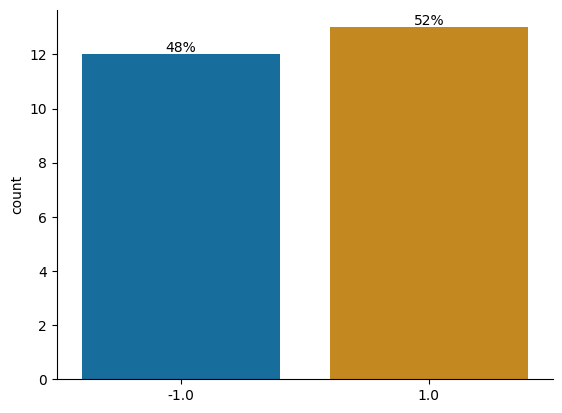

In [8]:
# Verificando a proporção das classes da resposta
fig, ax = plt.subplots()
sns.countplot(x=y_test, palette='colorblind', hue=y_test, legend=False)
heights = np.unique(y_test, return_counts=True)[1]
for i, height in enumerate(heights):
    ax.text(i, height, f'{height/len(y_test):.0%}', ha='center', va='bottom')
sns.despine()

Não há um desbalanceamento de classes considerável em relação à resposta, portanto, 60% de acurácia não pode ser considerada aceitável. Podemos verificar se o problema é linearmente separável.

<function matplotlib.pyplot.show(close=None, block=None)>

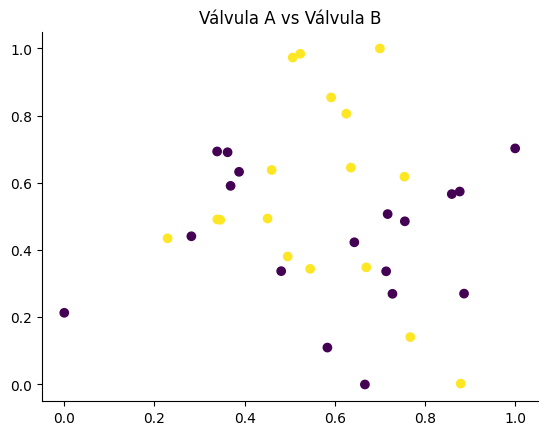

In [9]:
# Plotando o gráfico para verificação se as amostras são linearmente separáveis
plt.scatter(X[:,1],X[:,0],c=y)
plt.title("Válvula A vs Válvula B")
sns.despine()
plt.show

Aparentemente o problema não é linearmente separável

## Teste da rede com outras amostras

In [10]:
# Carrega os dados de teste como um pandas DataFrame
df_testes = pd.read_csv('../data/valvulasTestes.csv', header=None)

# Separa a base em sinais de entrada e saída
X = df_testes.loc[:, [0, 1, 2, 3]].values
y = df_testes.loc[:, 4].values

# Faz o escalonamento dos sinais de entrada
X = scaler.fit_transform(X)

In [11]:
# Predição dos dados de teste
# For entrada, saida in zip(X_test, y_test):
nTests = len(y)
y_pred = np.where(rede.activation_function(X) >= 0, 1, -1)
replace_columns = {0: 'X1', 1: 'X2', 2: 'X3', 3: 'X4', 4:'d'}
replace_index = {i:j for i, j in zip(range(15), range(1, 16))}
df_testes.rename(columns=replace_columns, index=replace_index, inplace=True)
df_testes['y(T1)'] = y_pred
df_testes

,X1,X2,X3,X4,d,y(T1)
1,0.9694,0.6909,0.4334,3.4965,-1,1
2,0.5427,1.3832,0.6390,4.0352,-1,-1
3,0.6081,-0.9196,0.5925,0.1016,1,1
4,-0.1618,0.4694,0.2030,3.0117,-1,-1
5,0.1870,-0.2578,0.6124,1.7749,-1,-1
6,0.4891,-0.5276,0.4378,0.6439,1,1
7,0.3777,2.0149,0.7423,3.3932,1,-1
8,1.1498,-0.4067,0.2469,1.5866,1,1
9,0.9325,1.0950,1.0359,3.3591,1,-1
10,0.5060,1.3317,0.9222,3.7174,-1,-1
